# Feature performance comparison

The purpose of this notebook is to compare the classification performance of the individual features, and their combination, for E. Coli

# Imports

In [1]:
import os
import sys
from IPython.display import display

sys.path.append('../src')
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.base import clone

import matplotlib.pyplot as plt

from yellowbrick.features import ParallelCoordinates
from yellowbrick.features import Rank1D, Rank2D

import pandas as pd
import numpy as np
import seaborn as sns

from dataset.transporter_dataset import create_dataset
from dataset.cluster_fasta import cd_hit
from features.labels import fasta_to_labels
from features.compositions import calculate_composition_feature
from features.pssm import calculate_pssm_feature
from features.coexp import calculate_coexp_feature
from models.eval import nested_crossval
from visualization.feature_plots import create_plot

# Globals

In [2]:
N_THREADS = 16
IDENTITY_THRESHOLD=70
TAX_ID = 9606
ORGANISM = "human"
LOG_FILE = "../logs/human_amino_sugar.log"

# Dataset

In [3]:
# Delete previous log
if os.path.exists(LOG_FILE):
    with open(LOG_FILE, "w"):
        pass

create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Membrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    verbose=True,
    outliers=["Q9HBR0", "Q07837"],
    tax_ids_filter=[TAX_ID],
    output_tsv=f"../data/datasets/{ORGANISM}_amino_sugar.tsv",
    output_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_log=LOG_FILE,
)


,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
Q9BWM7,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN3,Sideroflexin-3,NaN,9606,MGELPLDINIQEPRWDQSTFLGRARHFFTVTDPRNLLLSGAQLEAS...
Q9BRV3,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,SLC50A1 RAG1AP1 SCP,Sugar transporter SWEET1 (HsSWEET1) (RAG1-acti...,2.A.123.1.4,9606,MEAGGFLDSLIYGACVVFTLGMFSAGLSDLRHMRMTRSVDNVQFLP...
Q5M8T2,Sugar transport,Membrane;Transmembrane,Transport,SLC35D3 FRCL1,Solute carrier family 35 member D3 (Fringe con...,2.A.7.15.5,9606,MRQLCRGRVLGISVAIAHGVFSGSLNILLKFLISRYQFSFLTLVQC...
Q969S0,Sugar transport,Membrane;Transmembrane,Transport,SLC35B4 YEA4 PSEC0055,UDP-xylose and UDP-N-acetylglucosamine transpo...,2.A.7.10.2,9606,MRPALAVGLVFAGCCSNVIFLELLARKHPGCGNIVTFAQFLFIAVE...
O75387,Amino-acid transport,Membrane;Transmembrane,Transport,SLC43A1 LAT3 PB39 POV1,Large neutral amino acids transporter small su...,2.A.1.44.1,9606,MAPTLQQAYRRRWWMACTAVLENLFFSAVLLGWGSLLIILKNEGFY...
...,...,...,...,...,...,...,...,...
Q9BYW1,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,SLC2A11 GLUT11,"Solute carrier family 2, facilitated glucose t...",2.A.1.1.44,9606,MRALRRLIQGRILLLTICAAGIGGTFQFGYNLSIINAPTLHIQEFT...
P11169,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,SLC2A3 GLUT3,"Solute carrier family 2, facilitated glucose t...",2.A.1.1.91,9606,MGTQKVTPALIFAITVATIGSFQFGYNTGVINAPEKIIKEFINKTL...
P14672,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,SLC2A4 GLUT4,"Solute carrier family 2, facilitated glucose t...",2.A.1.1.80,9606,MPSGFQQIGSEDGEPPQQRVTGTLVLAVFSAVLGSLQFGYNIGVIN...


## Clustering

In [4]:
cd_hit(
    executable_location="cd-hit",
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_fasta=f"../data/datasets/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
    log_file=LOG_FILE,
    identity_threshold=IDENTITY_THRESHOLD,
    n_threads=N_THREADS,
    memory=4096,
    verbose=True,
)

## Annotations

In [5]:
df_annotations = pd.read_table(f"../data/datasets/{ORGANISM}_amino_sugar.tsv", index_col=0)
df_annotations.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
Q9BWM7,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN3,Sideroflexin-3,NaN,9606,MGELPLDINIQEPRWDQSTFLGRARHFFTVTDPRNLLLSGAQLEAS...
Q9BRV3,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,SLC50A1 RAG1AP1 SCP,Sugar transporter SWEET1 (HsSWEET1) (RAG1-acti...,2.A.123.1.4,9606,MEAGGFLDSLIYGACVVFTLGMFSAGLSDLRHMRMTRSVDNVQFLP...
Q5M8T2,Sugar transport,Membrane;Transmembrane,Transport,SLC35D3 FRCL1,Solute carrier family 35 member D3 (Fringe con...,2.A.7.15.5,9606,MRQLCRGRVLGISVAIAHGVFSGSLNILLKFLISRYQFSFLTLVQC...
Q969S0,Sugar transport,Membrane;Transmembrane,Transport,SLC35B4 YEA4 PSEC0055,UDP-xylose and UDP-N-acetylglucosamine transpo...,2.A.7.10.2,9606,MRPALAVGLVFAGCCSNVIFLELLARKHPGCGNIVTFAQFLFIAVE...
O75387,Amino-acid transport,Membrane;Transmembrane,Transport,SLC43A1 LAT3 PB39 POV1,Large neutral amino acids transporter small su...,2.A.1.44.1,9606,MAPTLQQAYRRRWWMACTAVLENLFFSAVLLGWGSLLIILKNEGFY...


# Feature generation

## Labels

In [6]:
fasta_to_labels(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv",
)
df_labels = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv",
    index_col=0,
)
df_labels.labels.value_counts()

Amino-acid transport    48
Sugar transport         34
Name: labels, dtype: int64

## AAC

In [7]:
calculate_composition_feature(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}_aac.tsv",
    feature_type="aac",
)

## Reading dataframes

In [8]:
df_aac = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}_aac.tsv",
    index_col=0,
)

# Functions

In [9]:
def get_feature_stats(df_features, df_labels_, labels=["Amino-acid transport", "Sugar transport"]):
    df_stats = pd.concat(
        {
            "corr": df_features.corrwith(
                df_labels_.labels.transform(lambda x: 1.0 if x == labels[1] else 0.0)
            ),
            "mean": df_features.mean(),
            "std": df_features.std(),
        },
        axis=1,
    )

    df_stats["corr_abs"] = df_stats["corr"].abs()

    df_stats["mean0"] = df_features.loc[df_labels_[df_labels_.labels == labels[0]].index].mean()
    df_stats["mean1"] = df_features.loc[df_labels_[df_labels_.labels == labels[1]].index].mean()

    df_stats["median0"] = df_features.loc[
        df_labels_[df_labels_.labels == labels[0]].index
    ].median()
    df_stats["median1"] = df_features.loc[
        df_labels_[df_labels_.labels == labels[1]].index
    ].median()

    df_stats["mediandiff"] = (df_stats["median0"] - df_stats["median1"]).abs()
    df_stats = df_stats.sort_values("mediandiff", ascending=False)
    return df_stats

In [10]:
def get_independent_test_set(
    df_features, df_labels_, labels=["Amino-acid transport", "Sugar transport"], test_size=0.2
):
    X = df_features.to_numpy()
    y = np.where(df_labels_.labels == labels[1], 1, 0)
    feature_names = df_features.columns.to_numpy()
    sample_names = df_features.index.to_numpy()
    (
        X_train,
        X_test,
        y_train,
        y_test,
        sample_names_train,
        sample_names_test,
    ) = train_test_split(
        X, y, sample_names, stratify=y, random_state=42, shuffle=True, test_size=test_size
    )
    return (
        X_train,
        X_test,
        y_train,
        y_test,
        sample_names_train,
        sample_names_test,
        feature_names,
    )


In [11]:
def print_validation_results(y_true_, y_pred_, labels = ["Amino", "Sugar"]):
    report_dict = classification_report(y_true=y_true_, y_pred=y_pred_, output_dict=True)
    report_dict = {
        labels[0]: report_dict['0'],
        labels[1]: report_dict['1'],
        "Macro": report_dict["macro avg"],
        "Weighted": report_dict["weighted avg"]
    }
    report_df = pd.DataFrame.from_dict(report_dict)
    confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_true_, y_pred_),
        columns=labels,
        index=labels,
    )
    return report_df, confusion_matrix_df

# Individual Features

## AAC

### Stats, Plots

In [12]:
get_feature_stats(df_aac, df_labels)

,corr,mean,std,corr_abs,mean0,mean1,median0,median1,mediandiff
G,0.330764,0.078460,0.016179,0.330764,0.073983,0.084779,0.076141,0.084391,0.008250
I,-0.243412,0.067497,0.019474,0.243412,0.071462,0.061899,0.072837,0.064867,0.007970
P,-0.185978,0.047826,0.012097,0.185978,0.049708,0.045169,0.049634,0.041925,0.007709
L,0.264524,0.133139,0.023298,0.264524,0.127984,0.140417,0.127623,0.134506,0.006883
N,-0.204271,0.032058,0.010375,0.204271,0.033831,0.029555,0.033461,0.027875,0.005586
A,0.129789,0.081882,0.019591,0.129789,0.079755,0.084885,0.076779,0.081950,0.005170
K,-0.072430,0.035918,0.012764,0.072430,0.036691,0.034826,0.038704,0.033984,0.004720
D,-0.193269,0.026965,0.010087,0.193269,0.028596,0.024663,0.028117,0.023889,0.004228
R,0.126909,0.037150,0.012346,0.126909,0.035840,0.039001,0.033205,0.037126,0.003920
V,-0.113785,0.080466,0.012851,0.113785,0.081689,0.078739,0.081725,0.077942,0.003783


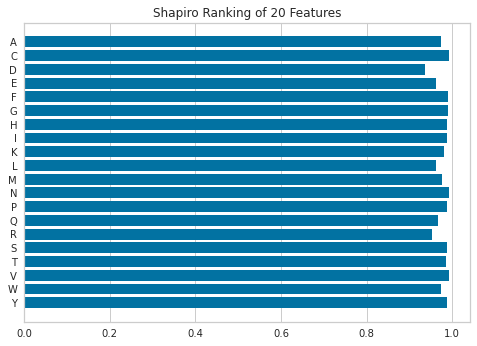

In [13]:
from yellowbrick.features import rank1d
rank1d(df_aac.to_numpy(), np.where(df_labels.labels == "Sugar transport", 1, 0), features = df_aac.columns)
plt.show()

### Independent test set

In [14]:
(
    X_train,
    X_test,
    y_train,
    y_test,
    sample_names_train,
    sample_names_test,
    feature_names,
) = get_independent_test_set(df_aac, df_labels, test_size=0.2)

### Preprocessing

In [15]:
# preprocess = make_pipeline(StandardScaler())
# X_train_processed = preprocess.fit_transform(X_train)

### Model selection

SVC (with default RBF kernel) and linear SVM look the most promising. I will choose RBF and switch to linear if the model is overfitting.

In [16]:
for estimator in [
    LinearSVC(),
    LinearSVC(class_weight="balanced"),
    SVC(),
    SVC(class_weight="balanced"),
    GaussianNB(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
    RandomForestClassifier(class_weight="balanced"),
    SGDClassifier(),
]:
    pipeline = make_pipeline(StandardScaler(), estimator)
    scores = cross_val_score(estimator, X_train, y_train, scoring="f1_macro")
    print("### ", estimator)
    print(f"CV folds: {scores.round(3)}")
    print(f"Mean: {scores.mean().round(3)}")
    print(f"Std: {scores.std().round(3)}")


###  LinearSVC()
CV folds: [0.35  0.35  0.381 0.381 0.381]
Mean: 0.369
Std: 0.015
###  LinearSVC(class_weight='balanced')
CV folds: [0.513 0.845 0.606 0.405 0.69 ]
Mean: 0.612
Std: 0.15
###  SVC()
CV folds: [0.458 0.35  0.567 0.278 0.567]
Mean: 0.444
Std: 0.116
###  SVC(class_weight='balanced')
CV folds: [0.513 0.845 0.675 0.405 0.675]
Mean: 0.623
Std: 0.151
###  GaussianNB()
CV folds: [0.513 0.675 0.745 0.513 0.675]
Mean: 0.624
Std: 0.095
###  KNeighborsClassifier()
CV folds: [0.575 0.575 0.513 0.511 0.575]
Mean: 0.55
Std: 0.031
###  RandomForestClassifier()
CV folds: [0.513 0.675 0.639 0.35  0.458]
Mean: 0.527
Std: 0.119
###  RandomForestClassifier(class_weight='balanced')
CV folds: [0.513 0.639 0.639 0.458 0.35 ]
Mean: 0.52
Std: 0.11
###  SGDClassifier()
CV folds: [0.536 0.35  0.381 0.278 0.405]
Mean: 0.39
Std: 0.085


### Parameter tuning

In [17]:
gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), SVC()),
    param_grid={
        "svc__class_weight": ["balanced", None],
        "svc__C": [0.1, 1, 10],
        "svc__gamma": ["scale", 1e-0, 1e-1, 1e-2],
    },
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
)
gsearch.fit(X_train, y_train)
print(gsearch.best_params_)
print(gsearch.best_score_)
best_estimator_svc = gsearch.best_estimator_


{'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 0.01}
0.6138030760089583


### Dimensionality reduction

In [18]:
df_train = pd.DataFrame(X_train, columns=feature_names, index=sample_names_train)
get_feature_stats(df_train, df_labels.loc[df_train.index])

,corr,mean,std,corr_abs,mean0,mean1,median0,median1,mediandiff
L,0.319089,0.132892,0.024544,0.319089,0.126342,0.142111,0.126333,0.135084,0.008752
N,-0.251708,0.032355,0.010263,0.251708,0.034516,0.029314,0.035646,0.027778,0.007868
G,0.317947,0.078476,0.015257,0.317947,0.074418,0.084186,0.074494,0.082031,0.007537
R,0.130968,0.038216,0.013223,0.130968,0.036767,0.040254,0.032930,0.040385,0.007455
I,-0.218621,0.067955,0.018450,0.218621,0.071329,0.063207,0.072015,0.065217,0.006798
P,-0.154672,0.047714,0.012873,0.154672,0.049380,0.045371,0.047865,0.042308,0.005557
V,-0.180204,0.081023,0.013017,0.180204,0.082985,0.078261,0.082572,0.077640,0.004933
D,-0.204019,0.027174,0.009984,0.204019,0.028878,0.024776,0.028453,0.024038,0.004414
K,-0.071955,0.035430,0.013254,0.071955,0.036228,0.034308,0.036217,0.031936,0.004281
Q,0.068783,0.031233,0.008763,0.068783,0.030729,0.031943,0.027525,0.031185,0.003660


In [19]:
params_svc = {
    "svc__class_weight": ["balanced"],
    "svc__C": [1, 10, 100],
    "svc__gamma": ["scale", 1e-1, 1e-2, 1e-3],
    "selectkbest__k": list(range(1, 20)),
}
gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), SelectKBest(), SVC()),
    param_grid=params_svc,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
    refit=True,
)
gsearch.fit(X_train, y_train)
print(gsearch.best_params_)
print(gsearch.best_score_.round(3))
print(
    "Removed features ",
    feature_names[~gsearch.best_estimator_["selectkbest"].get_support()],
)
best_estimator_svc_kbest = gsearch.best_estimator_


{'selectkbest__k': 14, 'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.671
Removed features  ['A' 'E' 'F' 'Q' 'T' 'Y']


In [20]:
params_svc = {
    "svc__class_weight": ["balanced", None],
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ["scale",1e-1, 1e-2, 1e-3],
    "pca__n_components": np.linspace(0.8, 0.99, 20),
}
gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), PCA(), SVC()),
    param_grid=params_svc,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
    refit=True,
)
gsearch.fit(X_train, y_train)
print(gsearch.best_params_)
print(gsearch.best_score_)
best_estimator_svc_pca = gsearch.best_estimator_
display(
    pd.DataFrame.from_records(
        [
            feature_names,
            gsearch.best_estimator_["pca"].components_[0],
            gsearch.best_estimator_["pca"].components_[1],
            gsearch.best_estimator_["pca"].components_[2],
        ],
        index=["Feature", "Contrib. PC1", "Contrib. PC2", "Contrib. PC3"],
    )
    .T.set_index("Feature")
    .sort_values("Contrib. PC1", ascending=False)
)

pca = PCA()
pca.fit(X_train)
csum = np.cumsum(pca.explained_variance_ratio_)
print("Number of components to explain variance:", np.argmax(csum >= 0.93) + 1)


{'pca__n_components': 0.8200000000000001, 'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.680058275058275


,Contrib. PC1,Contrib. PC2,Contrib. PC3
Feature,,,
G,0.292196,0.075781,-0.205078
A,0.285977,0.20073,-0.233172
L,0.276812,-0.19994,-0.221125
P,0.267199,0.114004,0.373787
R,0.222661,0.368936,0.283644
C,0.165814,-0.2558,0.096281
W,0.15267,-0.242973,0.17874
S,0.079748,-0.348014,0.017727
Q,0.06847,0.213984,0.051695


Number of components to explain variance: 12


### Validation

In [21]:
best_estimator = best_estimator_svc_kbest
best_scores = cross_val_score(
    estimator=clone(best_estimator), X=X_train, y=y_train, scoring="f1_macro"
)
print(f"Train scores: {best_scores.mean().round(3)}+-{best_scores.std().round(3)}")

y_pred = best_estimator.predict(X_test)
y_true = y_test.copy()

report_df, confusion_matrix_df = print_validation_results(y_true, y_pred, labels=["Amino", "Sugar"])
display(report_df.round(3))
display(confusion_matrix_df)

Train scores: 0.671+-0.06


,Amino,Sugar,Macro,Weighted
precision,0.667,0.500,0.583,0.598
recall,0.600,0.571,0.586,0.588
f1-score,0.632,0.533,0.582,0.591
support,10.000,7.000,17.000,17.000


,Amino,Sugar
Amino,6,4
Sugar,3,4


In [22]:
best_estimator = best_estimator_svc_pca
best_scores = cross_val_score(
    estimator=clone(best_estimator), X=X_train, y=y_train, scoring="f1_macro"
)
print(f"Train scores: {best_scores.mean().round(3)}+-{best_scores.std().round(3)}")

y_pred = best_estimator.predict(X_test)
y_true = y_test.copy()

report_df, confusion_matrix_df = print_validation_results(y_true, y_pred, labels=["Amino", "Sugar"])
display(report_df.round(3))
display(confusion_matrix_df)

Train scores: 0.68+-0.115


,Amino,Sugar,Macro,Weighted
precision,0.636,0.500,0.568,0.580
recall,0.700,0.429,0.564,0.588
f1-score,0.667,0.462,0.564,0.582
support,10.000,7.000,17.000,17.000


,Amino,Sugar
Amino,7,3
Sugar,4,3


## With nested LOOCV

There are not enough samples in dataset, trying different eval method

In [23]:
from sklearn.model_selection import LeaveOneOut

X = df_aac.values
labels = df_labels.labels
y = np.where(labels == "Sugar transport", 1, 0)


params_svc = {
    "svc__class_weight": ["balanced"],
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ["scale", 1e-1, 1e-2, 1e-3],
}
gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), SVC()),
    param_grid=params_svc,
    cv=LeaveOneOut(),
    scoring="f1_macro",
    # n_jobs=1,
    return_train_score=True,
    refit=True,
)
# the score does not make a difference, since it's either 1 (correct) or 0 (incorrect)
res = cross_val_score(gsearch, X, y, scoring="f1_macro", n_jobs=-1, cv=LeaveOneOut())
print(res.mean())


params_svc = {
    "svc__class_weight": ["balanced"],
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ["scale", 1e-1, 1e-2, 1e-3],
    "pca__n_components": [0.8, 0.9],
}
gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), PCA(), StandardScaler(), SVC()),
    param_grid=params_svc,
    cv=LeaveOneOut(),
    scoring="f1_macro",
    # n_jobs=1,
    return_train_score=True,
    refit=True,
)
# the score does not make a difference, since it's either 1 (correct) or 0 (incorrect)
res = cross_val_score(gsearch, X, y, scoring="f1_macro", n_jobs=-1, cv=LeaveOneOut())
print(res.mean())


0.6707317073170732
0.6829268292682927


In [24]:
from sklearn.model_selection import LeaveOneOut

X = df_aac.values
labels = df_labels.labels
y = np.where(labels == "Sugar transport", 1, 0)


params_svc = {
    "svc__class_weight": ["balanced"],
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ["scale", 1e-1, 1e-2, 1e-3],
}
gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), SVC()),
    param_grid=params_svc,
    cv=LeaveOneOut(),
    scoring="f1_macro",
    # n_jobs=1,
    return_train_score=True,
    refit=True,
)
# the score does not make a difference, since it's either 1 (correct) or 0 (incorrect)
res = cross_val_predict(gsearch, X, y, n_jobs=-1, cv=LeaveOneOut())
print(f1_score(y, res, average="macro"))


params_svc = {
    "svc__class_weight": ["balanced"],
    "svc__C": [0.1, 1, 10],
    # "svc__gamma": ["scale", 1e-1, 1e-2, 1e-3],
    "pca__n_components": [0.8, 0.9],
}
gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), PCA(), StandardScaler(), SVC()),
    param_grid=params_svc,
    cv=LeaveOneOut(),
    scoring="f1_macro",
    # n_jobs=1,
    # return_train_score=True,
    refit=True,
)
# the score does not make a difference, since it's either 1 (correct) or 0 (incorrect)
res = cross_val_predict(gsearch, X, y, n_jobs=-1, cv=LeaveOneOut())
print(f1_score(y, res, average="macro"))

0.6667168447990366
0.6872616323417239
